In [1]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [2]:
from src.modules import conf, fit, evl, preprocess, compare, compare_features
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, XGBRFRegressor
warnings.simplefilter("ignore")
from feature_engine.creation import MathFeatures
import pickle
from datetime import datetime

/home/zahradnik/PycharmProjects/master_thesis/src/modules/__init__.py
/home/zahradnik/PycharmProjects/master_thesis


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [5]:
race_day = '2023-10-21-11-30'

In [6]:
data = fit.load_pcls(
        'zahradnik',
        'running',
        conf["Paths"]["pcl"],
        datetime.strptime(race_day, "%Y-%m-%d-%H-%M")

    )

100%|██████████| 386/386 [00:01<00:00, 377.40it/s]


In [7]:
low_dist, high_dist = preprocess.segment_data(data)
len(low_dist),len(high_dist)

(144, 242)

In [8]:
test_df = preprocess.load_test_activity(path="tracks/bechovice.gpx",
                                        race_day =race_day)
print(len(test_df))

2122


In [9]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
len(train_df)

681291

In [10]:
train_df.to_csv("src/output/zahradnik_train_df.csv")

In [11]:
train_df.index.min()

Timestamp('2022-08-30 13:50:32')

In [12]:
train_df.index.max()

Timestamp('2023-08-29 15:47:38')

In [13]:
len(train_df.columns),len(test_df.columns)

(134, 61)

In [14]:
len(train_df),len(test_df)

(681291, 2122)

In [15]:
len(train_df[test_df.columns].columns),len(test_df.columns)

(61, 61)

# Cadence

In [16]:
clf = XGBRegressor()

In [17]:
clf.fit(train_df[test_df.columns], train_df.cadence)
test_df['cadence'] = clf.predict(test_df)
test_df['cadence'].mean()

92.23834

In [18]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

# Heart Rate

In [19]:
clf.fit(train_df[test_df.columns], train_df.heart_rate)
test_df["heart_rate"] = clf.predict(test_df)
test_df["heart_rate"].mean()

177.81383

In [20]:
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)

In [21]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [22]:
clf.fit(train_df[test_df.columns], train_df.enhanced_speed)
cols_in_model = test_df.columns
test_df["enhanced_speed"] = clf.predict(test_df)

In [23]:
pickle.dump(clf, open("src/models/zahradnik.sav", 'wb'))

In [24]:
percent_delay = int(len(test_df) * 0.02)  ## 2% delay

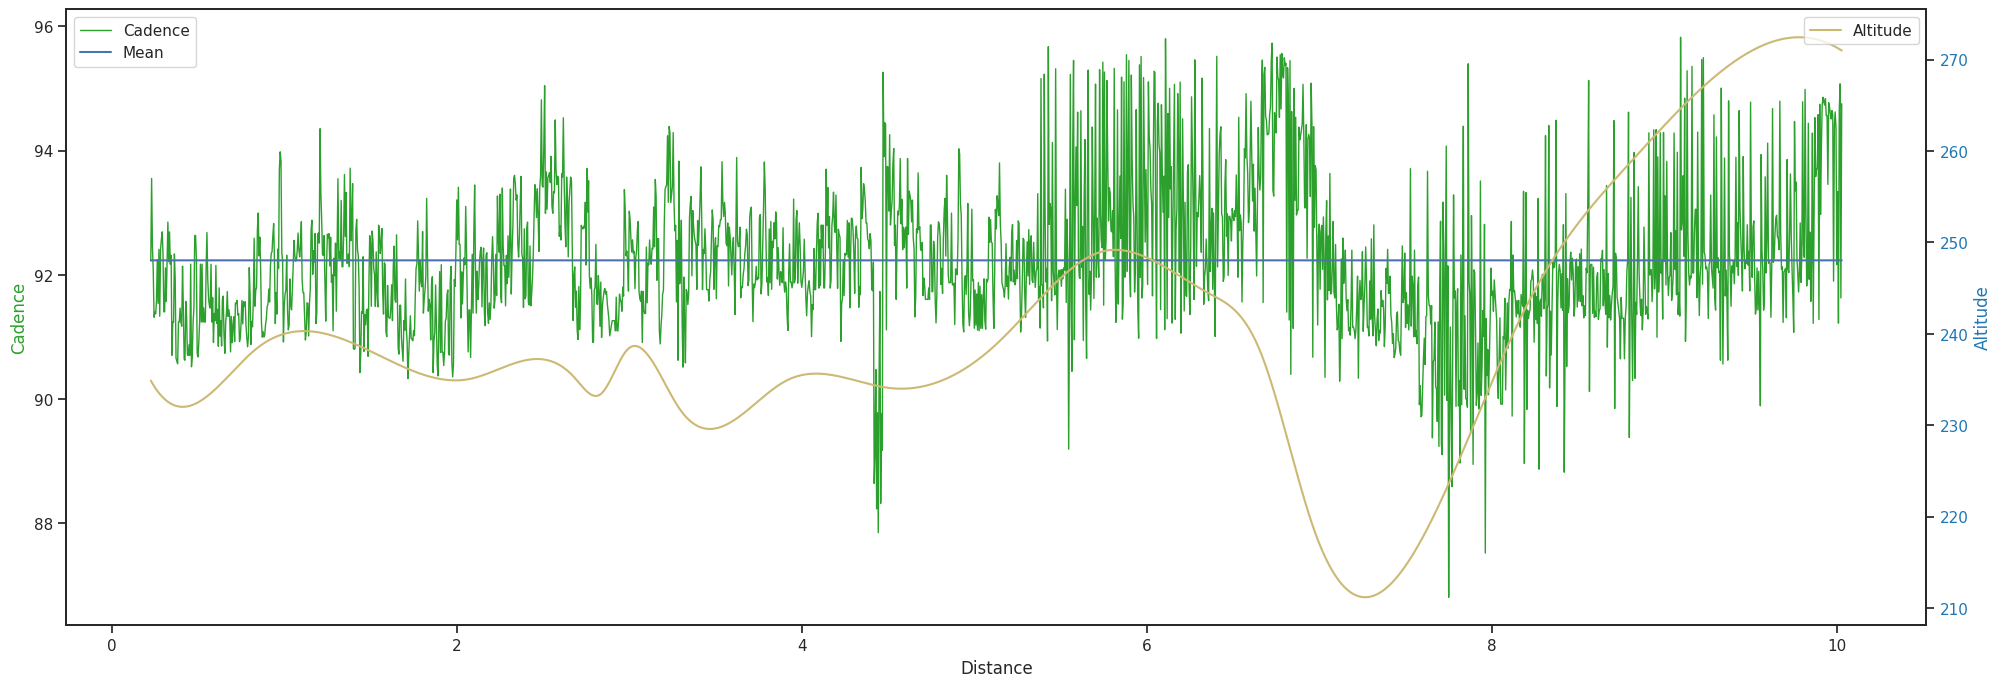

In [47]:
cad_plot = evl.plot(df=test_df[percent_delay:], pred=test_df['cadence'][percent_delay:], ylabel="Cadence", color="green")

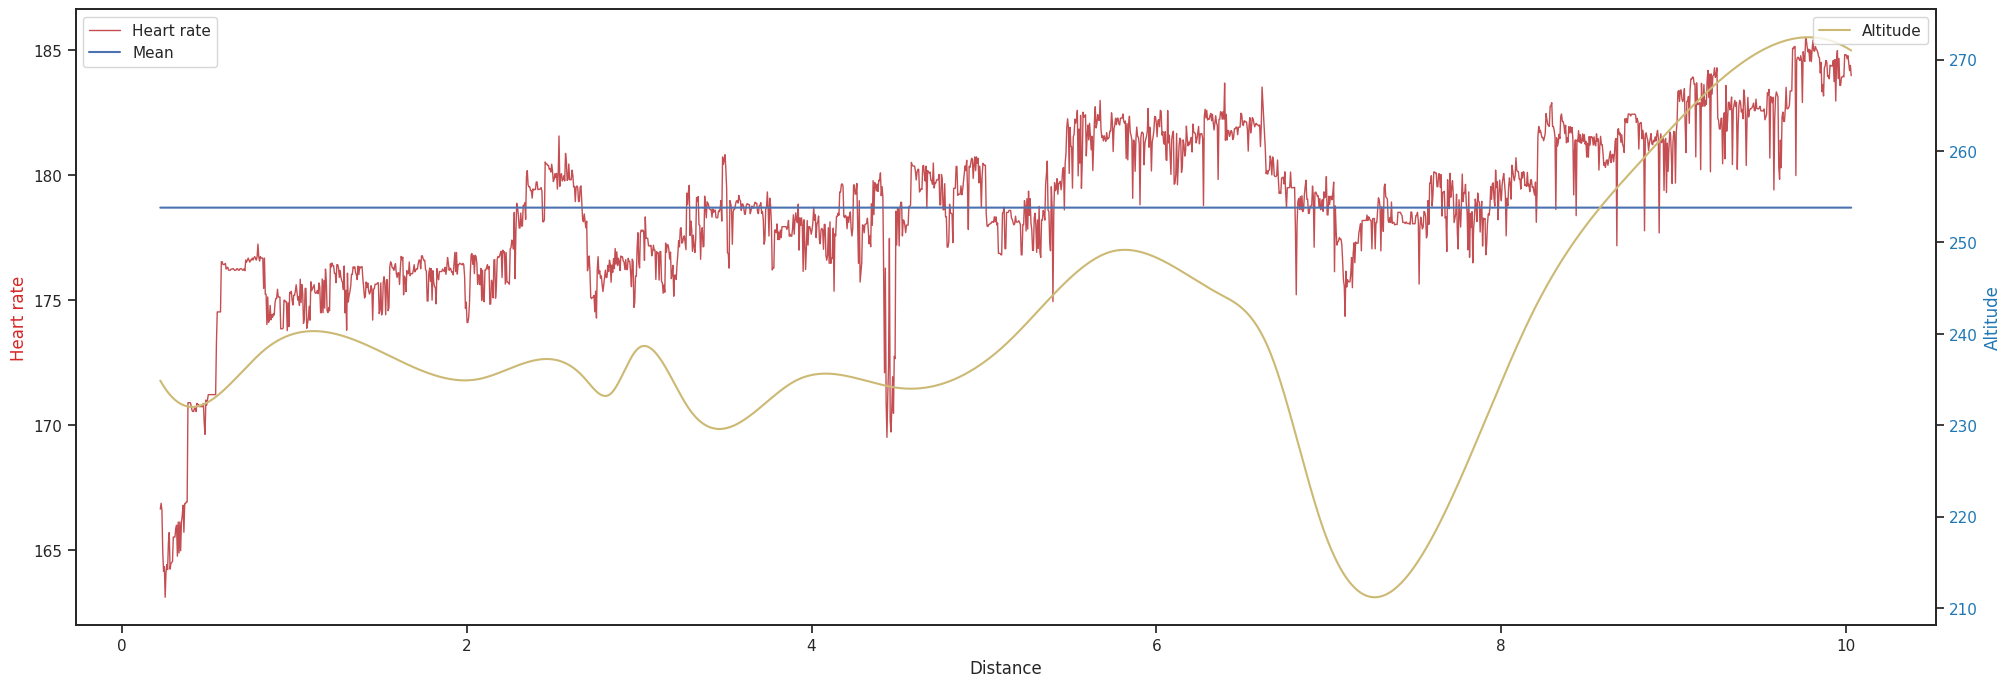

In [26]:
hr_plot = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],ylabel="Heart rate", color="red")

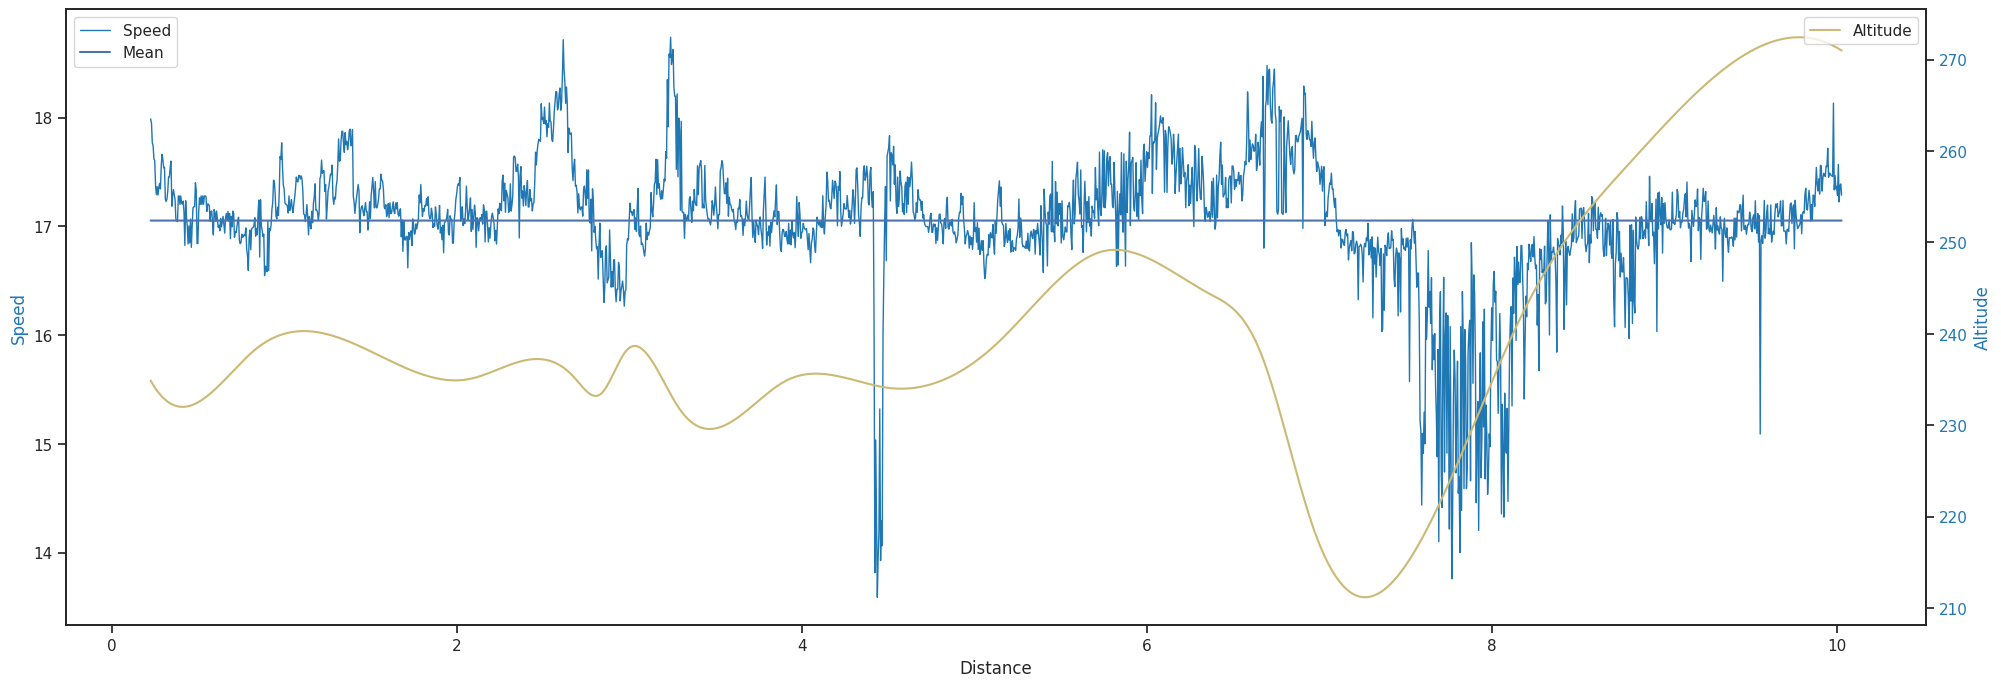

In [45]:
speed_plot = evl.plot(df=test_df[percent_delay:],pred=test_df["enhanced_speed"][percent_delay:],ylabel="Speed", color="blue")

In [28]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate),np.mean(test_df["enhanced_speed"])

(92.23834, 177.81383, 17.04525)

In [29]:
y_pred_ridge = [x if x > 15 else np.mean(test_df["enhanced_speed"]) or x if x < 30 else np.mean(test_df["enhanced_speed"]) for x in test_df["enhanced_speed"]]

In [30]:
pd.DataFrame(cols_in_model,columns=["col"]).to_csv("columns_in_model.csv")

In [31]:
test_df.to_csv(f"src/output/zahradnik_bechovice.csv")

In [32]:
import math

# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(test_df["enhanced_speed"])) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
if seconds == 60:
    seconds=0
    minutes+=1
final_time = f'Final time: {minutes}:{seconds}'
f'Final time: {minutes}:{seconds}'

'Final time: 35:18'

In [33]:
from datetime import datetime, timedelta
(datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d-%M")

'2023-11-30-16'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

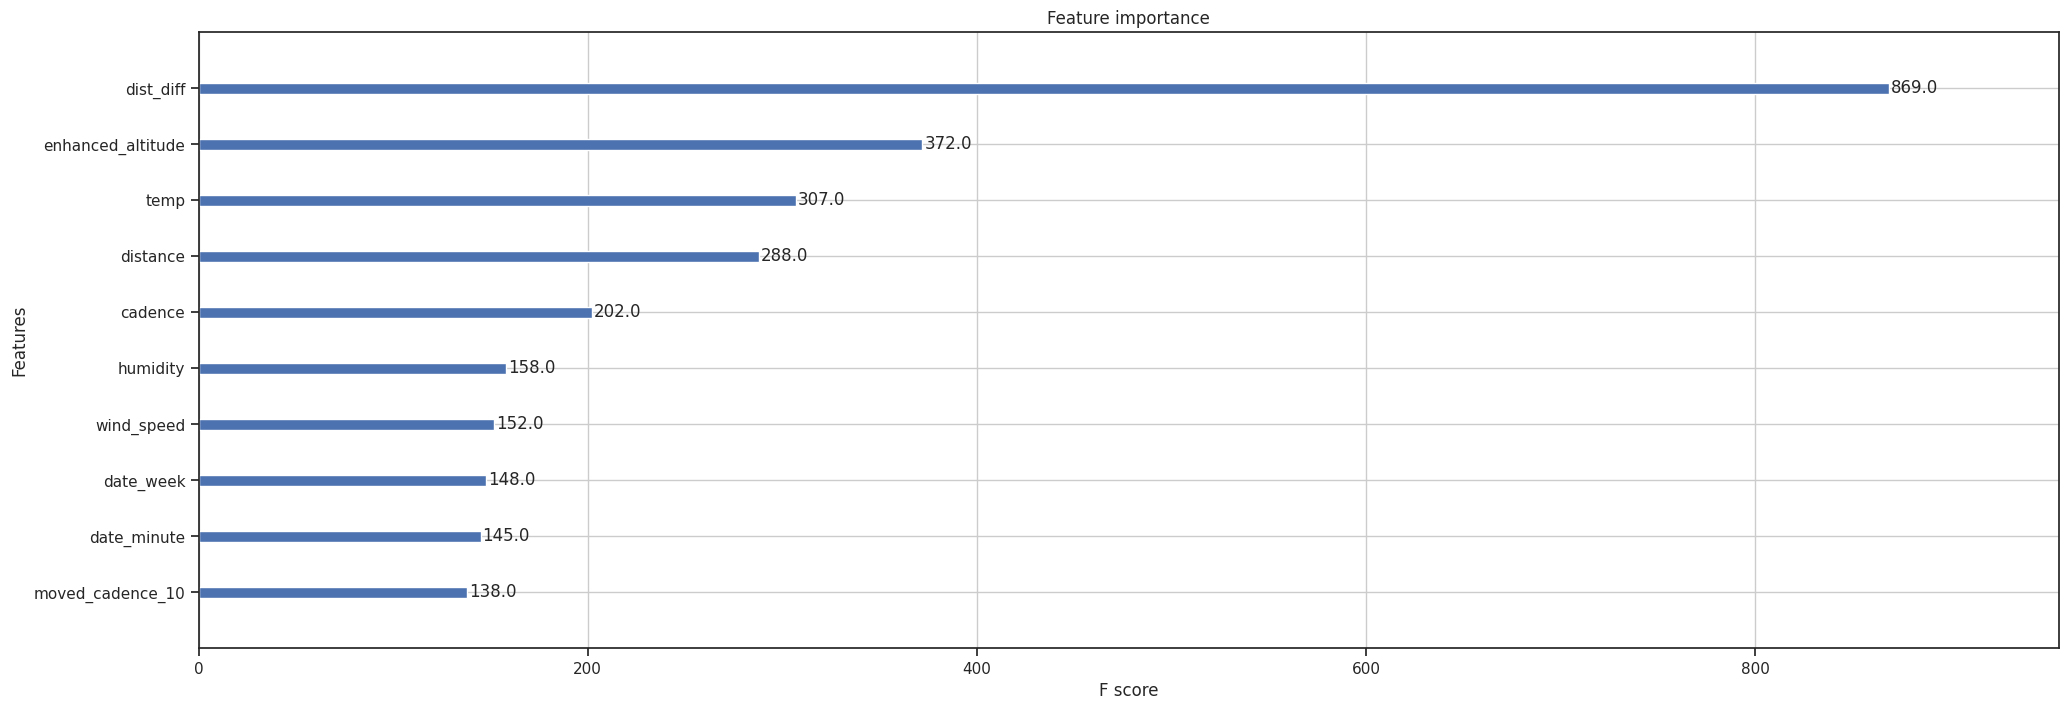

In [34]:
import xgboost as xgb
xgb.plot_importance(clf, max_num_features=10)

In [35]:
hradec = preprocess.load_test_activity(path="tracks/hradec_half.gpx",
                                        race_day ='2023-11-13-11-30')
fit.get_final_df(train_df=train_df,
                 test_df=hradec,
                 model=XGBRegressor(),
                 race_name="hradec",
                 athlete_name="zahradnik")

'74:58'

In [36]:
silvestrak = preprocess.load_test_activity(path="tracks/silvestrak.gpx",
                                        race_day ='2023-11-10-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=silvestrak,
                 model=XGBRegressor(),
                 race_name="silvestrak",
                 athlete_name="zahradnik")

'17:50'

In [37]:
boston = preprocess.load_test_activity(path="tracks/boston.gpx",
                                        race_day ='2023-11-12-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=boston,
                 model=XGBRegressor(),
                 race_name="boston",
                 athlete_name="zahradnik")

'146:23'

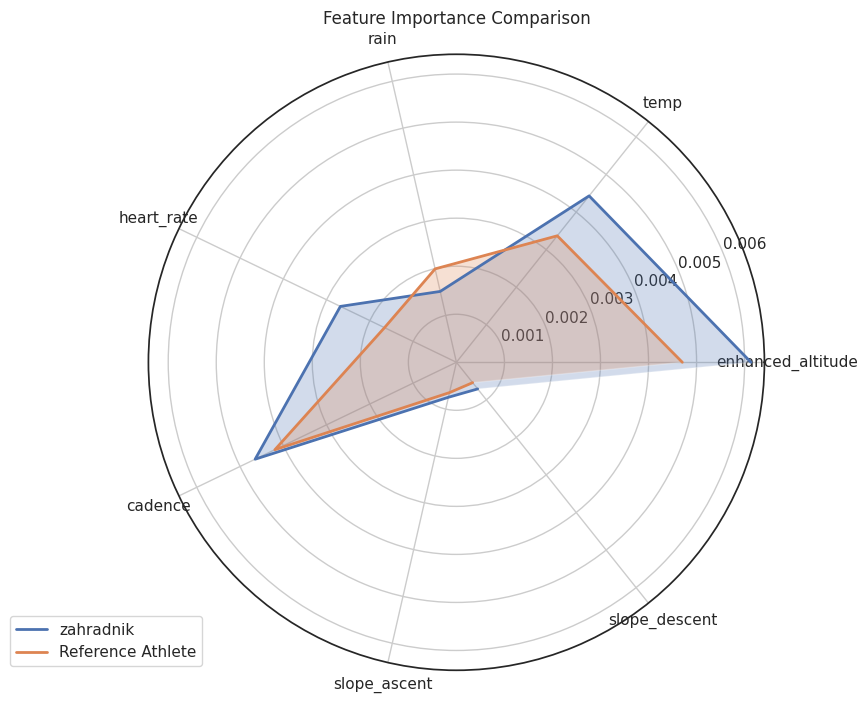

In [38]:
from src.modules.compare import Compare

compare = Compare(ref_athlete_name="zimola")
compare.calc_importances(cols=test_df.columns, clf=clf)
radar= compare.plot_radar()

In [41]:
from src.modules import ui_output
ui_output.gen_map(track_name="bechovice")

LOG: HTML page with the plots next to each other has been created.


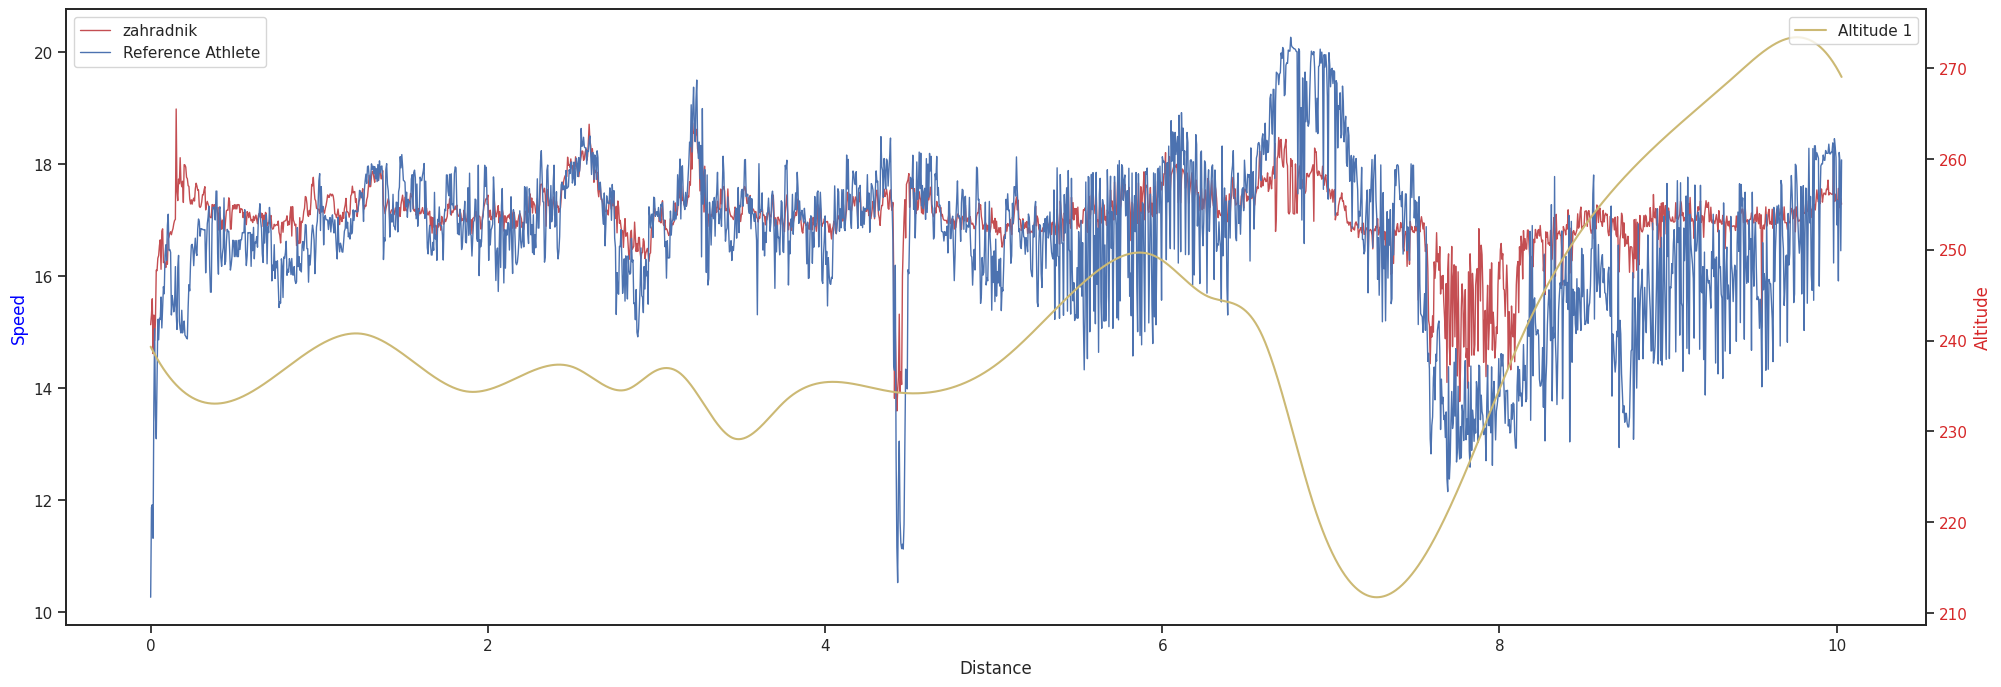

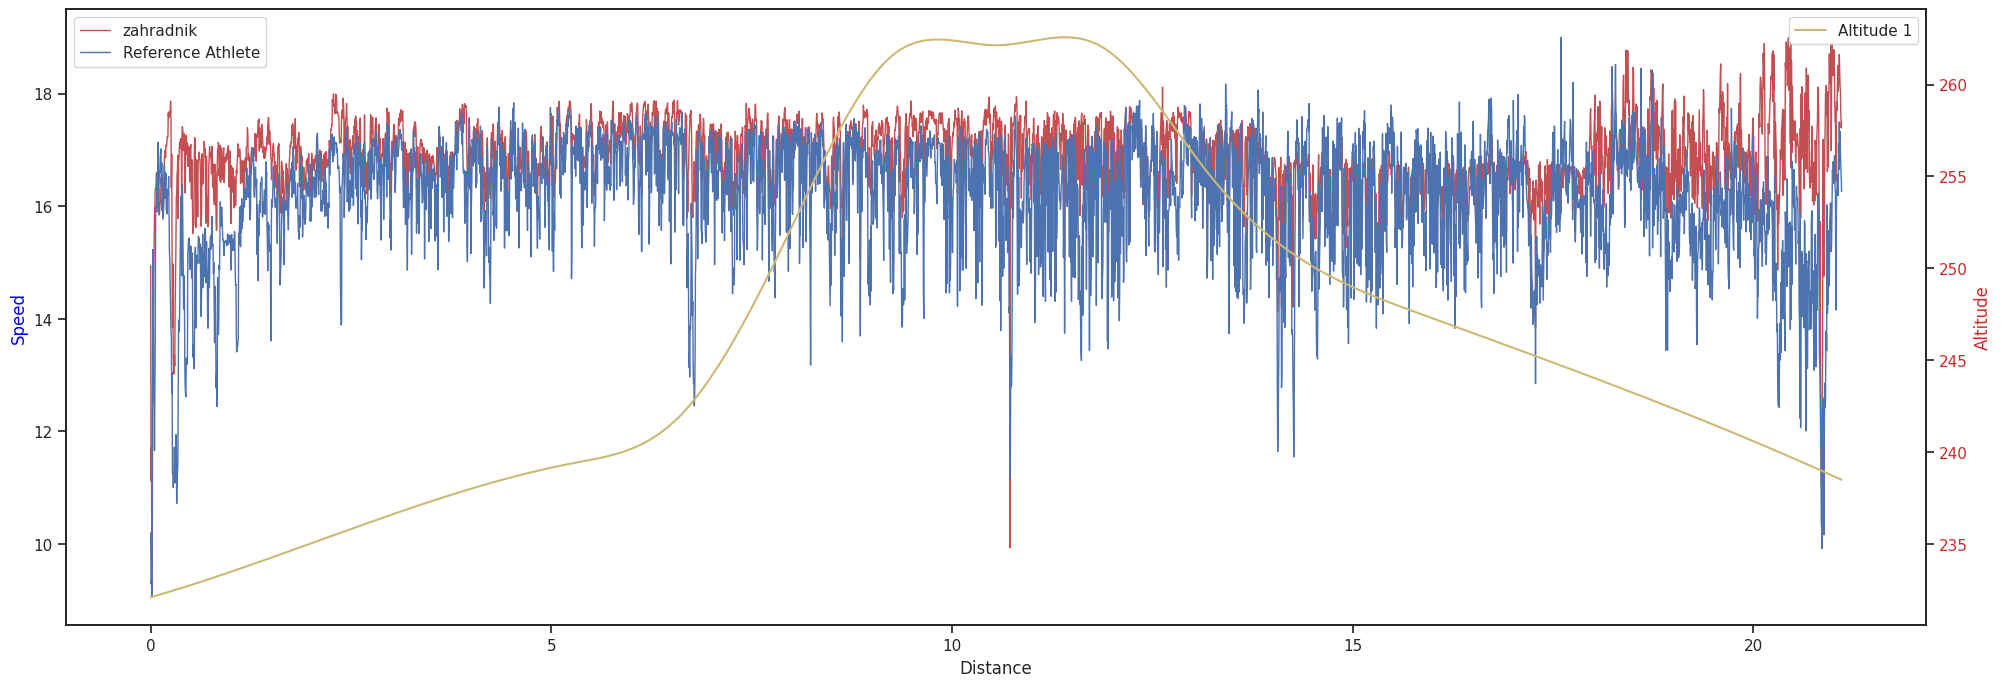

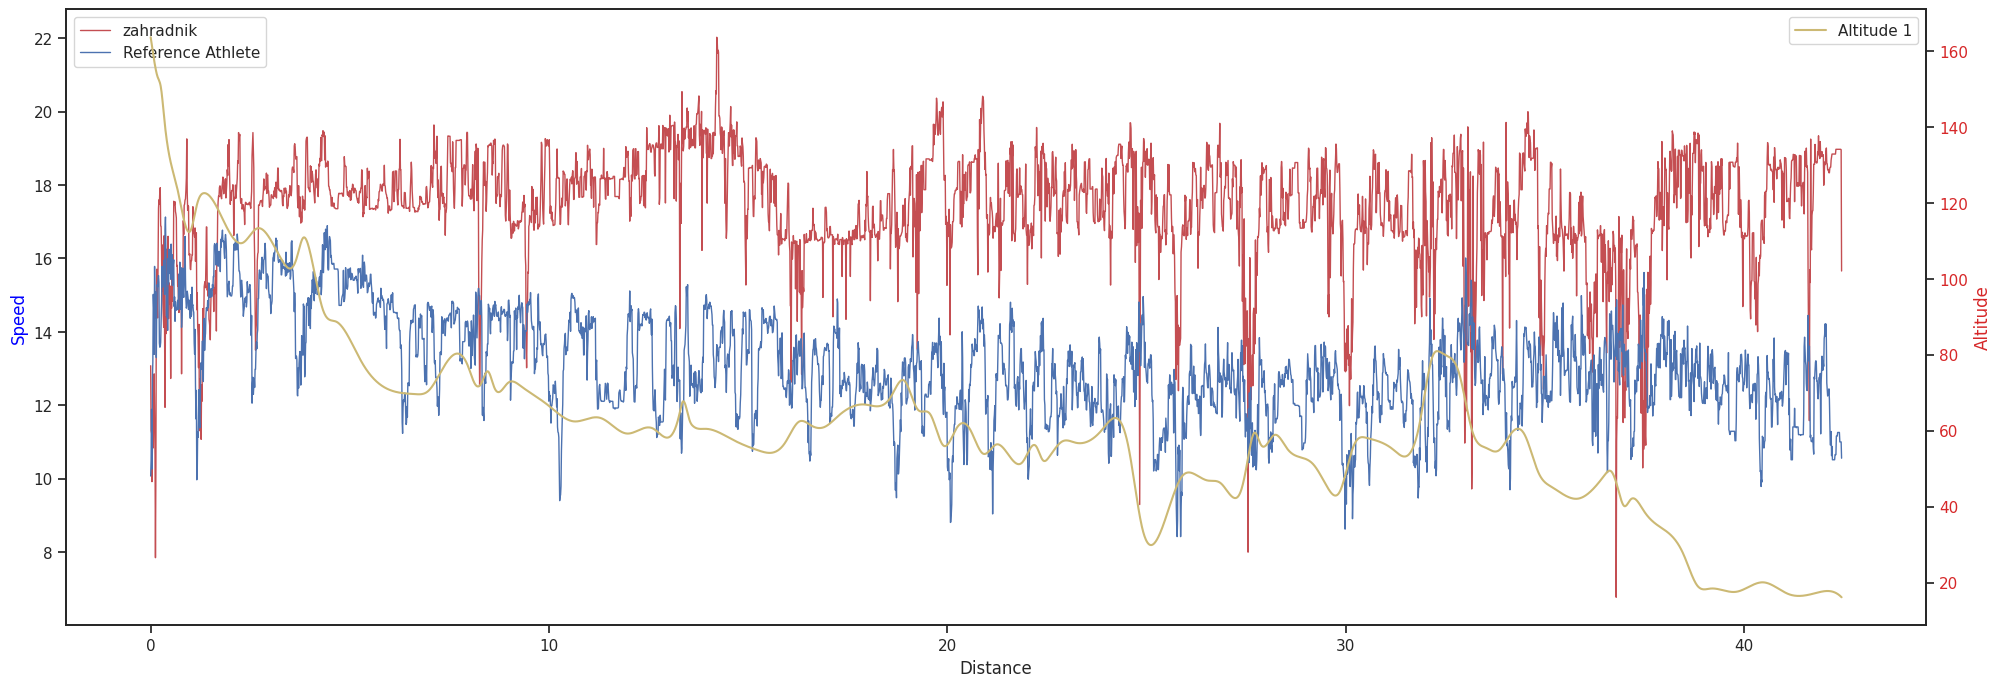

In [42]:
ui_output.save_report(athlete_name=conf["Athlete"]["name"],
                      activity_type=conf["Athlete"]["activity_type"],
                      activity_name="bechovice.gpx"
                      .replace(".gpx","")
                      .capitalize(),
                      cad_plot=cad_plot,
                      hr_plot=hr_plot,
                      speed_plot=speed_plot,
                      final_time=final_time,
                      df=test_df,
                      radar_plot = radar,
                      track_name="bechovice"
                      )